In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Data files are located in the data/ subdirectory

data/GenshinImpact_30Maret2024_MostRelevant_non995.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB

In [3]:
df = pd.read_csv("data/GenshinImpact_30Maret2024_MostRelevant_non995.csv")
df = df[[
    'content',
    'sentiment'
]]
df['sentiment'].value_counts()

sentiment
POSITIVE    510
NEGATIVE    434
Name: count, dtype: int64

In [4]:
df.dtypes
df.shape
df.describe().T

,count,unique,top,freq
content,944,944,Tbf I love the open world! Nice story (only re...,1
sentiment,944,2,POSITIVE,510


In [5]:
#lowercase function
def lowercase(text):
    text = text.lower()
    return text

#abrreviation
def abbreviation(text):
    text=re.sub("isn't",'is not',text)
    text=re.sub("he's",'he is',text)
    text=re.sub("wasn't",'was not',text)
    text=re.sub("there's",'there is',text)
    text=re.sub("couldn't",'could not',text)
    text=re.sub("won't",'will not',text)
    text=re.sub("they're",'they are',text)
    text=re.sub("she's",'she is',text)
    text=re.sub("there's",'there is',text)
    text=re.sub("wouldn't",'would not',text)
    text=re.sub("haven't",'have not',text)
    text=re.sub("that's",'that is',text)
    text=re.sub("you've",'you have',text)
    text=re.sub("te's",'te is',text)
    text=re.sub("what's",'what is',text)
    text=re.sub("weren't",'were not',text)
    text=re.sub("we're",'we are',text)
    text=re.sub("hasn't",'has not',text)
    text=re.sub("you'd",'you would',text)
    text=re.sub("shouldn't",'should not',text)
    text=re.sub("let's",'let us',text)
    text=re.sub("they've",'they have',text)
    text=re.sub("you'll",'you will',text)
    text=re.sub("i'm",'i am',text)
    text=re.sub("we've",'we have',text)
    text=re.sub("it's",'it is',text)
    text=re.sub("don't",'do not',text)
    text=re.sub("that´s",'that is',text)
    text=re.sub("i´m",'i am',text)
    text=re.sub("it’s",'it is',text)
    text=re.sub("she´s",'she is',text)
    text=re.sub("he’s'",'he is',text)
    text=re.sub('i’m','i am',text)
    text=re.sub('i’d','i did',text)
    text=re.sub("he’s'",'he is',text)
    text=re.sub('there’s','there is',text)

    return text

#remove emoticons, url, number, spec.char, puncts
def remove(text):
    text = text.strip(" ")
    text = re.sub('https?://\S+|www\.\S+', '', text) # removing URL links
    text = re.sub(r"\b\d+\b", "", text) # removing number 
    text = re.sub('<.*?>+', '', text) # removing special characters, 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # punctuations
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)
    text = re.sub(r'[0-9]', '', text)

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)   

    return text

#lemmatize function
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatization_verb(review):
    lemma_result = wordnet_lemmatizer.lemmatize(review, 'v')
    if(lemma_result == review):
        lemma_result = wordnet_lemmatizer.lemmatize(review, 'n')
        if(lemma_result == review):
            lemma_result = wordnet_lemmatizer.lemmatize(review, 'a')
            if(lemma_result == review):
                lemma_result = wordnet_lemmatizer.lemmatize(review, 'r')
                if(lemma_result == review):
                    lemma_result = wordnet_lemmatizer.lemmatize(review, 's')
    return lemma_result 

# Define a function to perform POS tagging and filter for noun tokens
def pos_tagging(tokens):
    # tokens = word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    # Filter tokens that contain 'NN' (noun tags) and return only the words (tokens)
    filtered_tokens = [token[0] for token in tagged if 'NN' in token[1]]
    return filtered_tokens

In [6]:
#apply function

df['content'] = df['content'].apply(lowercase)
df['content'] = df['content'].apply(abbreviation)
df['content'] = df['content'].apply(remove)
df['content'].head()

0    tbf i love the open world nice story only rece...
1    first of all the prices in quest events and ot...
2    this is the best adventures game with fascinat...
3    it is the best game i played on android  but u...
4    now i do have a problem i am asian but in asia...
Name: content, dtype: object

In [7]:
#tokenizing

regexp = RegexpTokenizer('\w+')
df['tokenized'] = df['content'].apply(regexp.tokenize)
df['tokenized'].head()

0    [tbf, i, love, the, open, world, nice, story, ...
1    [first, of, all, the, prices, in, quest, event...
2    [this, is, the, best, adventures, game, with, ...
3    [it, is, the, best, game, i, played, on, andro...
4    [now, i, do, have, a, problem, i, am, asian, b...
Name: tokenized, dtype: object

In [8]:
#stopword removal

from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
df['tokenized'] = df['tokenized'].apply(lambda x : [item for item in x if item not in stopwords])

df['tokenized'].head()

0    [tbf, love, open, world, nice, story, recently...
1    [first, prices, quest, events, things, satisfa...
2    [best, adventures, game, fascinating, environm...
3    [best, game, played, android, unfortunately, g...
4    [problem, asian, asia, server, ping, always, s...
Name: tokenized, dtype: object

In [9]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [10]:
#lemmatizing proses
#nltk.download("corpora")
df['lemmatized'] = df['tokenized'].apply(lambda x: [lemmatization_verb(review) for review in x])

In [11]:
#combine string

df['clean_text'] = df['lemmatized'].apply(lambda x : ' '.join([item for item in x]))
df['clean_text']

0      tbf love open world nice story recently scener...
1      first price quest event thing satisfaction pla...
2      best adventure game fascinate environment beau...
3      best game play android unfortunately gacha gam...
4      problem asian asia server ping always stick m ...
                             ...                        
939    many unwanted file use include junk file add c...
940    exploration good combat good character weapon ...
941    great game amount long dialogue involve story ...
942    like game major problem start quest trial tian...
943    love play game get decently far love collect s...
Name: clean_text, Length: 944, dtype: object

In [12]:
#filter pos tagging to get noun list

df['nouns'] = df['lemmatized'].apply(pos_tagging)
df['nouns']

0      [tbf, world, story, reward, work, lantern, yea...
1      [price, event, thing, satisfaction, player, ac...
2      [adventure, game, fascinate, environment, stor...
3      [game, play, game, game, game, option, customi...
4      [problem, asia, server, try, achieve, player, ...
                             ...                        
939    [use, junk, file, option, make, download, reso...
940    [exploration, combat, character, animation, ex...
941    [game, amount, story, time, consumingnot, opti...
942    [game, problem, start, trial, tianqui, somethi...
943    [play, game, side, character, interaction, exp...
Name: nouns, Length: 944, dtype: object

In [13]:
#merge for each list to string

df['nouns_merge'] = df['nouns'].apply(lambda x: ' '.join([item for item in x]))

In [14]:
df.to_csv('./dataset_clean.csv', index=False)

In [15]:
visualize_df = pd.read_csv('./dataset_clean.csv')
visualize_df

,content,sentiment,tokenized,lemmatized,clean_text,nouns,nouns_merge
0,tbf i love the open world nice story only rece...,POSITIVE,"['tbf', 'love', 'open', 'world', 'nice', 'stor...","['tbf', 'love', 'open', 'world', 'nice', 'stor...",tbf love open world nice story recently scener...,"['tbf', 'world', 'story', 'reward', 'work', 'l...",tbf world story reward work lantern year patro...
1,first of all the prices in quest events and ot...,NEGATIVE,"['first', 'prices', 'quest', 'events', 'things...","['first', 'price', 'quest', 'event', 'thing', ...",first price quest event thing satisfaction pla...,"['price', 'event', 'thing', 'satisfaction', 'p...",price event thing satisfaction player account ...
2,this is the best adventures game with fascinat...,POSITIVE,"['best', 'adventures', 'game', 'fascinating', ...","['best', 'adventure', 'game', 'fascinate', 'en...",best adventure game fascinate environment beau...,"['adventure', 'game', 'fascinate', 'environmen...",adventure game fascinate environment story gam...
3,it is the best game i played on android but u...,POSITIVE,"['best', 'game', 'played', 'android', 'unfortu...","['best', 'game', 'play', 'android', 'unfortuna...",best game play android unfortunately gacha gam...,"['game', 'play', 'game', 'game', 'game', 'opti...",game play game game game option customise char...
4,now i do have a problem i am asian but in asia...,NEGATIVE,"['problem', 'asian', 'asia', 'server', 'ping',...","['problem', 'asian', 'asia', 'server', 'ping',...",problem asian asia server ping always stick m ...,"['problem', 'asia', 'server', 'try', 'achieve'...",problem asia server try achieve player lot pro...
...,...,...,...,...,...,...,...
939,there are so many unwanted files that are not ...,NEGATIVE,"['many', 'unwanted', 'files', 'use', 'includin...","['many', 'unwanted', 'file', 'use', 'include',...",many unwanted file use include junk file add c...,"['use', 'junk', 'file', 'option', 'make', 'dow...",use junk file option make download resource pl...
940,exploration is good combat is good characters ...,NEGATIVE,"['exploration', 'good', 'combat', 'good', 'cha...","['exploration', 'good', 'combat', 'good', 'cha...",exploration good combat good character weapon ...,"['exploration', 'combat', 'character', 'animat...",exploration combat character animation excelle...
941,its a great game it is just the amount of long...,POSITIVE,"['great', 'game', 'amount', 'long', 'dialogues...","['great', 'game', 'amount', 'long', 'dialogue'...",great game amount long dialogue involve story ...,"['game', 'amount', 'story', 'time', 'consuming...",game amount story time consumingnot option ski...
942,i like the game but i have a major problem i s...,NEGATIVE,"['like', 'game', 'major', 'problem', 'started'...","['like', 'game', 'major', 'problem', 'start', ...",like game major problem start quest trial tian...,"['game', 'problem', 'start', 'trial', 'tianqui...",game problem start trial tianqui something im ...


In [16]:
visualize_df = visualize_df.replace({'POSITIVE': 1, 'NEGATIVE':0})
visualize_df.head()

/tmp/ipykernel_33/2399931238.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  visualize_df = visualize_df.replace({'POSITIVE': 1, 'NEGATIVE':0})


,content,sentiment,tokenized,lemmatized,clean_text,nouns,nouns_merge
0,tbf i love the open world nice story only rece...,1,"['tbf', 'love', 'open', 'world', 'nice', 'stor...","['tbf', 'love', 'open', 'world', 'nice', 'stor...",tbf love open world nice story recently scener...,"['tbf', 'world', 'story', 'reward', 'work', 'l...",tbf world story reward work lantern year patro...
1,first of all the prices in quest events and ot...,0,"['first', 'prices', 'quest', 'events', 'things...","['first', 'price', 'quest', 'event', 'thing', ...",first price quest event thing satisfaction pla...,"['price', 'event', 'thing', 'satisfaction', 'p...",price event thing satisfaction player account ...
2,this is the best adventures game with fascinat...,1,"['best', 'adventures', 'game', 'fascinating', ...","['best', 'adventure', 'game', 'fascinate', 'en...",best adventure game fascinate environment beau...,"['adventure', 'game', 'fascinate', 'environmen...",adventure game fascinate environment story gam...
3,it is the best game i played on android but u...,1,"['best', 'game', 'played', 'android', 'unfortu...","['best', 'game', 'play', 'android', 'unfortuna...",best game play android unfortunately gacha gam...,"['game', 'play', 'game', 'game', 'game', 'opti...",game play game game game option customise char...
4,now i do have a problem i am asian but in asia...,0,"['problem', 'asian', 'asia', 'server', 'ping',...","['problem', 'asian', 'asia', 'server', 'ping',...",problem asian asia server ping always stick m ...,"['problem', 'asia', 'server', 'try', 'achieve'...",problem asia server try achieve player lot pro...


In [17]:
#Working with the most Frequent Words: 
from collections import Counter
cnt = Counter()
for text in visualize_df["nouns_merge"].values:
    for word in text.split():
        cnt[word] += 1

# cnt.most_common(10)
temp = pd.DataFrame(cnt.most_common(10))
temp.columns=['word', 'count']
temp

,word,count
0,game,1907
1,character,519
2,play,501
3,player,337
4,story,279
5,time,276
6,reward,228
7,year,212
8,thing,167
9,star,163


In [18]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(1)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])
visualize_df["nouns_merge"] = visualize_df["nouns_merge"].apply(lambda text: remove_freqwords(text))
visualize_df.head()

,content,sentiment,tokenized,lemmatized,clean_text,nouns,nouns_merge
0,tbf i love the open world nice story only rece...,1,"['tbf', 'love', 'open', 'world', 'nice', 'stor...","['tbf', 'love', 'open', 'world', 'nice', 'stor...",tbf love open world nice story recently scener...,"['tbf', 'world', 'story', 'reward', 'work', 'l...",tbf world story reward work lantern year patro...
1,first of all the prices in quest events and ot...,0,"['first', 'prices', 'quest', 'events', 'things...","['first', 'price', 'quest', 'event', 'thing', ...",first price quest event thing satisfaction pla...,"['price', 'event', 'thing', 'satisfaction', 'p...",price event thing satisfaction player account ...
2,this is the best adventures game with fascinat...,1,"['best', 'adventures', 'game', 'fascinating', ...","['best', 'adventure', 'game', 'fascinate', 'en...",best adventure game fascinate environment beau...,"['adventure', 'game', 'fascinate', 'environmen...",adventure fascinate environment story event th...
3,it is the best game i played on android but u...,1,"['best', 'game', 'played', 'android', 'unfortu...","['best', 'game', 'play', 'android', 'unfortuna...",best game play android unfortunately gacha gam...,"['game', 'play', 'game', 'game', 'game', 'opti...",play option customise character option player ...
4,now i do have a problem i am asian but in asia...,0,"['problem', 'asian', 'asia', 'server', 'ping',...","['problem', 'asian', 'asia', 'server', 'ping',...",problem asian asia server ping always stick m ...,"['problem', 'asia', 'server', 'try', 'achieve'...",problem asia server try achieve player lot pro...


In [19]:
positive_aspect = visualize_df[visualize_df['sentiment'] == 1]
negative_aspect = visualize_df[visualize_df['sentiment'] == 0]

In [ ]:
#wordcloud for negative nouns
all_negative_aspects = ' '.join(word for word in negative_aspect['nouns_merge'])
wordcloud_negative = WordCloud(colormap='Reds_r', width=500, height=500, mode='RGBA', background_color='black', max_words=100).generate(all_negative_aspects)
plt.figure(figsize=(9,6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('')
plt.margins(x=0, y=0)
plt.show()

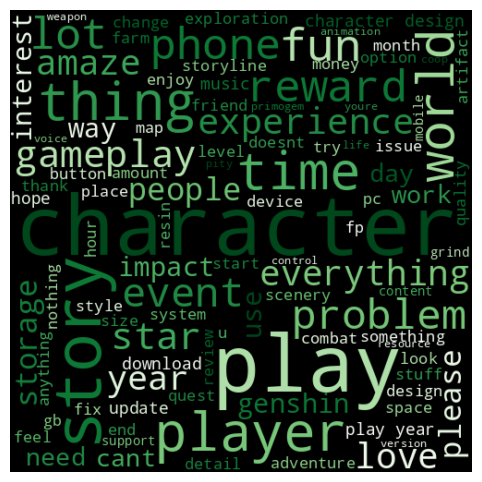

In [21]:
#wordcloud for positive nouns
all_positive_aspects = ' '.join(word for word in positive_aspect['nouns_merge'])
wordcloud_positive = WordCloud(colormap='Greens_r', width=500, height=500, mode='RGBA', background_color='black', max_words=100).generate(all_positive_aspects)
plt.figure(figsize=(9,6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('')
plt.margins(x=0, y=0)
plt.show()

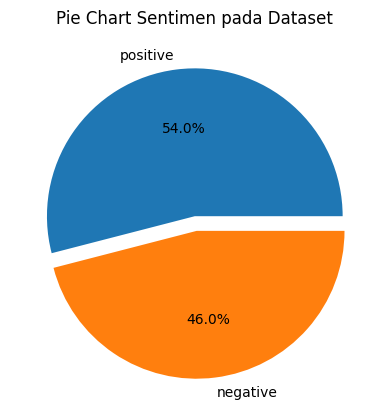

In [22]:
sentiment_data = visualize_df['sentiment']
plt.pie(sentiment_data.value_counts(), labels=['positive', 'negative'], explode=[0, 0.1], autopct='%1.1f%%')
plt.title('Pie Chart Sentimen pada Dataset')
plt.show()

In [23]:
dataset = pd.read_csv("./dataset_clean.csv")
dataset = dataset[[
    'clean_text',
    'sentiment'
]]

dataset = dataset.replace({'NEGATIVE':0, 'POSITIVE':1})
dataset.head()

/tmp/ipykernel_33/3787349709.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset = dataset.replace({'NEGATIVE':0, 'POSITIVE':1})


,clean_text,sentiment
0,tbf love open world nice story recently scener...,1
1,first price quest event thing satisfaction pla...,0
2,best adventure game fascinate environment beau...,1
3,best game play android unfortunately gacha gam...,1
4,problem asian asia server ping always stick m ...,0


In [24]:
X = dataset['clean_text']
y = dataset['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42) #rasio 90:10

In [25]:
print("Jumlah Data Training dan Testing (90:10)")
print("Data Training: \t"+ str(len(X_train)))
print("Data Testing : \t" + str(len(X_test)))

Jumlah Data Training dan Testing (90:10)
Data Training: 	849
Data Testing : 	95


In [26]:
#count vectorizer for training and testing data
count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count  = count_vectorizer.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_count, y_train)

In [27]:
nb = MultinomialNB()
nb.fit(X_train_res, y_train_res)
y_pred = nb.predict(X_test_count)

In [28]:
#Evaluasi Model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=['negative', 'positive'])

print("Naive Bayes Model Accuracy : ", accuracy)
print("\nClassification Report : \n", classification_rep)

Naive Bayes Model Accuracy :  0.8421052631578947

Classification Report : 
               precision    recall  f1-score   support

    negative       0.84      0.78      0.81        40
    positive       0.84      0.89      0.87        55

    accuracy                           0.84        95
   macro avg       0.84      0.83      0.84        95
weighted avg       0.84      0.84      0.84        95



In [29]:
y_test

96     1
265    1
811    0
23     1
30     0
      ..
506    1
266    0
168    1
332    0
451    0
Name: sentiment, Length: 95, dtype: int64

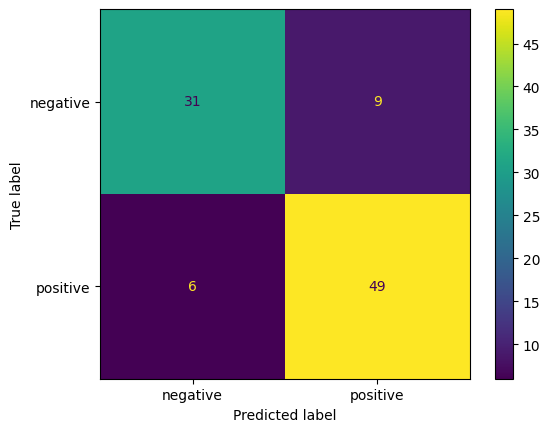

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# # cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['negative', 'positive'])
cmd.plot()

In [31]:
import textwrap 
myinput = "the game is bored and there isn't something to do"
text = myinput
myinput = lowercase(myinput)
myinput = abbreviation(myinput)
myinput = remove(myinput)
myinput = pd.DataFrame([myinput], columns=['input'])
# myinput = lemmatization_verb(myinput)
myinput['tokenized'] = myinput['input'].apply(regexp.tokenize)
myinput['tokenized'] = myinput['tokenized'].apply(lambda x : [item for item in x if item not in stopwords])
myinput['tokenized'] = myinput['tokenized'].apply(lambda x: [lemmatization_verb(review) for review in x])
myinput['clean_text'] = myinput['tokenized'].apply(lambda x: ' '.join([item for item in x]))
myinput = myinput['clean_text'][0]

myinput_vec = count_vectorizer.transform([myinput])


# myrate = input("\nEnter a rating of the text: ")
predicted_sentiment = nb.predict(myinput_vec)
sentiment_scores = nb.predict_proba(myinput_vec)

if sentiment_scores[0][0] > sentiment_scores[0][1]:
    sentiment_label = 'negative'
else :
    sentiment_label = 'positive'

# print(textwrap.fill(myinput, width=150))
print(text)
print("="*100)
print(sentiment_label)


the game is bored and there isn't something to do
negative
